In [ ]:
!pip install --quiet -U langgraph langchain_openai
!pip install  gradio PyMuPDF langchain_community  pypdf langchain
!pip install sentence-transformers
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.5/361.5 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6

In [ ]:
# import cohere
import gradio as gr
import fitz  # PyMuPDF
import os
import hnswlib
from langchain_community.document_loaders import PyPDFLoader
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma


ModuleNotFoundError: No module named 'cohere'

In [ ]:
OPENAI_API_KEY = "bbf9640b5603473b8200e4bb9c0d03d3"
LANGCHAIN_API_KEY = "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"

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

# `add_messages`` essentially does this
# (with more robust handling)
# def add_messages(left: list, right: list):
#     return left + right


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
from langchain_core.tools import tool


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]


tools = [search]

In [ ]:
def load_pdfs(pdf_directory):
    texts = []
    for filename in os.listdir(pdf_directory):
        if filename.endswith('.pdf'):
            filepath = os.path.join(pdf_directory, filename)
            with fitz.open(filepath) as pdf:
                text = ""
                for page in pdf:
                    text += page.get_text()
                texts.append(text)
    return texts

pdf_texts = load_pdfs('/content/')

In [ ]:
def split_texts(texts, chunk_size=1000, overlap=20):
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap)
    documents = [Document(page_content=text, metadata={"source": f"Document_{i}"}) for i, text in enumerate(texts)]
    chunks = splitter.split_documents(documents)
    return [chunk.page_content for chunk in chunks]

pdf_chunks = split_texts(pdf_texts)
len(pdf_chunks)

In [ ]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda"}
embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)
#######################
vectordb = Chroma.from_documents(documents=pdf_chunks, embedding=embeddings, persist_directory="chroma_db")
#######################
retriever = vectordb.as_retriever()

In [ ]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

<ipython-input-5-fdad03f5602e>:3: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


In [ ]:
from langchain_openai import AzureChatOpenAI
llm = AzureChatOpenAI(
    openai_api_version="2023-03-15-preview",  # e.g., "2023-12-01-preview"
    azure_deployment="sparcgpt4-32",
    api_key=OPENAI_API_KEY,
    azure_endpoint = "https://hclsparcaimodel.openai.azure.com/",
    temperature=0,
)

In [ ]:
model = llm.bind_tools(tools)

In [ ]:
from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolInvocation


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function to execute tools
def call_tool(state):
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_call = last_message.tool_calls[0]
    action = ToolInvocation(
        tool=tool_call["name"],
        tool_input=tool_call["args"],
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a ToolMessage
    tool_message = ToolMessage(
        content=str(response), name=action.tool, tool_call_id=tool_call["id"]
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [tool_message]}

In [ ]:
from langgraph.graph import END, StateGraph, START

# Define a new graph
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [ ]:

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory, interrupt_before=["action"])

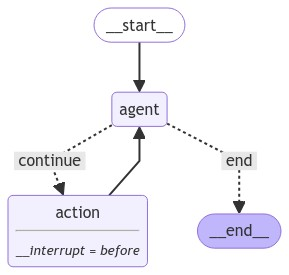

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "2"}}
inputs = [HumanMessage(content="hi! I'm bob")]
for event in app.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm bob
================================== Ai Message ==================================

Hello Bob! How can I assist you today?


In [ ]:
inputs = [HumanMessage(content="What did I tell you my name was?")]
for event in app.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What did I tell you my name was?
================================== Ai Message ==================================

You told me your name was Bob.


In [ ]:

inputs = [HumanMessage(content="what's the weather in sf now?")]
for event in app.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in sf now?
================================== Ai Message ==================================
Tool Calls:
  search (call_a2QAWuDcBx27QraIuQTSXs8I)
 Call ID: call_a2QAWuDcBx27QraIuQTSXs8I
  Args:
    query: current weather in San Francisco


In [ ]:

for event in app.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

<ipython-input-9-b12197032ddd>:34: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(


================================= Tool Message =================================
Name: search

["It's sunny in San Francisco, but you better look out if you're a Gemini 😈."]
================================== Ai Message ==================================

The current weather in San Francisco is sunny. However, if you're a Gemini, you might want to be careful out there!
